In [1]:
# Step 1: Import libraries
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

2026-01-07 06:01:38.079740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767765698.298234      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767765698.362302      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767765698.897150      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767765698.897194      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767765698.897197      24 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs found:", gpus)
else:
    print("No GPU found, using CPU")

# Optional: Set memory growth to prevent TensorFlow from grabbing all GPU memory
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Step 2: Set dataset paths
TRAIN_DIR = "/kaggle/input/brain-tumor-mri-dataset/Training"  # Change this to your Kaggle path
TEST_DIR  = "/kaggle/input/brain-tumor-mri-dataset/Testing"   # Change this to your Kaggle path

# Quick check: classes
print("Training classes:", os.listdir(TRAIN_DIR))
print("Testing classes:", os.listdir(TEST_DIR))

Training classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Testing classes: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [4]:
# Step 3: Image data generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # multi-class
    shuffle=True
)

# Validation generator (testing data)
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [5]:

# Step 4: Build ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base for feature extraction

# Add custom top layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),               # reduce overfitting
    Dense(4, activation='softmax')  # 4 classes
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1767765716.176536      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767765716.180642      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# Step 5: Train the model
EPOCHS = 25

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1767765727.746077      82 service.cc:152] XLA service 0x7a9cec04e3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767765727.746134      82 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767765727.746138      82 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767765729.652568      82 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/179 ━━━━━━━━━━━━━━━━━━━━ 41:57 14s/step - accuracy: 0.2188 - loss: 1.8760

I0000 00:00:1767765734.864329      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 121s 599ms/step - accuracy: 0.2508 - loss: 1.5741 - val_accuracy: 0.4104 - val_loss: 1.3153
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 423ms/step - accuracy: 0.3390 - loss: 1.3769 - val_accuracy: 0.4104 - val_loss: 1.2648
Epoch 3/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 427ms/step - accuracy: 0.3645 - loss: 1.3193 - val_accuracy: 0.3966 - val_loss: 1.2322
Epoch 4/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 428ms/step - accuracy: 0.3984 - loss: 1.2749 - val_accuracy: 0.4744 - val_loss: 1.2106
Epoch 5/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 423ms/step - accuracy: 0.4153 - loss: 1.2410 - val_accuracy: 0.4638 - val_loss: 1.1934
Epoch 6/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 425ms/step - accuracy: 0.4186 - loss: 1.2149 - val_accuracy: 0.5355 - val_loss: 1.1773
Epoch 7/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 418ms/step - accuracy: 0.4627 - loss: 1.1861 - val_accuracy: 0.4859 - val_loss: 1.1732
Epoch 8/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 409ms/step - accuracy: 0.4488 - loss: 1.1837 - va

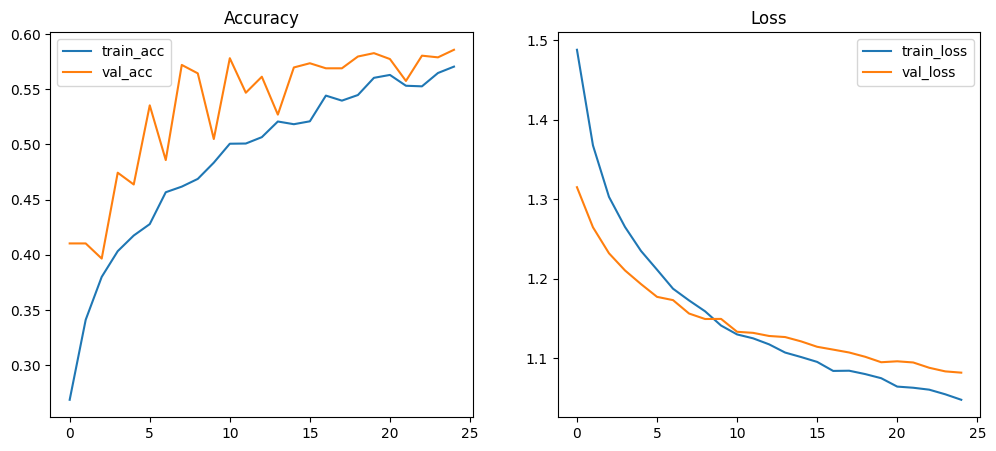

In [7]:
# Step 6: Plot training history
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()

plt.show()

In [8]:
# Step 7: Optional fine-tuning (unfreeze last few layers)
# Unfreeze last 10 layers of ResNet50
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Compile with smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for additional epochs
FT_EPOCHS = 10
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=FT_EPOCHS
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 495ms/step - accuracy: 0.4375 - loss: 2.6664 - val_accuracy: 0.3791 - val_loss: 2.1515
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 434ms/step - accuracy: 0.6583 - loss: 0.8486 - val_accuracy: 0.4912 - val_loss: 1.2358
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 434ms/step - accuracy: 0.7008 - loss: 0.7668 - val_accuracy: 0.7033 - val_loss: 0.8178
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 439ms/step - accuracy: 0.6978 - loss: 0.7397 - val_accuracy: 0.7147 - val_loss: 0.7773
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 436ms/step - accuracy: 0.6987 - loss: 0.7340 - val_accuracy: 0.7147 - val_loss: 0.7545
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 433ms/step - accuracy: 0.7152 - loss: 0.7062 - val_accuracy: 0.7193 - val_loss: 0.6833
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 434ms/step - accuracy: 0.7430 - loss: 0.6519 - val_accuracy: 0.7368 - val_loss: 0.6665
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 430ms/step - accuracy: 0.7465 - loss: 

# =========================
# Step: Evaluate on Test Data
# =========================


In [9]:
# Test data generator (only rescale, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,   # e.g., (224,224)
    batch_size=BATCH_SIZE,
    class_mode='categorical', # because this is multi-class
    shuffle=False             # important! do NOT shuffle for test
)

test_loss, test_acc = model.evaluate(test_gen)
print("Final Test Accuracy:", test_acc)
print("Final Test Loss:", test_loss)


Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.5105 - loss: 1.2197
Final Test Accuracy: 0.7208238244056702
Final Test Loss: 0.7445339560508728
